In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# A more complicated function

$$ M = 8, N = 12, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) \\
    \cos(-2x_2 + 1) \\
    2 \exp((x_3 + 10) / ||x||_2) \\
    \exp(\sin(\pi/2 + ||x||_2)) \\
    \left(\ln\left(3 + \left|\sum_{i=1}^{M} x_i\right|\right) - 1\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    \left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 \\
    \sqrt{\sin(\prod_{i=1}^M x_i) + 2} \\
    5 - \ln\left(1 + \left|\prod_{i=1}^M x_i\right|\right) \\
    \sin(x_1) + \cos(x_2) + \ln(1 + |x_3|) + x_4^2 + |x_5| + \sqrt{|x_6|} + \sin^2(x_7) + \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    \sin(||x||_2) + \cos(||x||_2) - \sum_{i=1}^M x_i \\
    1 - ||x||_2^2
\end{bmatrix}$$

In [147]:
M = 8
sin = Function(F=np.sin, DF=np.cos, M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, M=1, N=1)
log = Function(F=lambda x: np.log(np.abs(x)), DF=lambda x: 1 / x, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
abs = Function(F=np.abs, DF=lambda x: np.sign(x), M=1, N=1)
sqrt = Function(F=lambda x: np.sqrt(np.abs(x)), DF=lambda x: 0.5 / np.sqrt(np.abs(x)) * np.sign(x), M=1, N=1)
norm = Function(F=np.linalg.norm, DF=lambda x: x / np.linalg.norm(x), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda _: np.ones(M), M=M, N=1)
mul_ = Function(F=lambda x: np.array(np.prod(x)), DF=lambda x: np.prod(x) / x, M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda _: np.eye(M)[k], M=M, N=1)
constM = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), M=M, N=1)
const1 = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(1), M=1, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda _: np.array(c), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos))
F2 = compose(proj(1), mul_const(-2) + const1(1), cos)
F3 = compose((proj(2) + constM(10)) / norm, 2 * exp)
F4 = compose(norm + constM(np.pi / 2), sin, exp)
F5 = compose(compose(sum_, abs) + constM(3), log - const1(1), square)
F6 = compose(proj(5), sin, square, exp, cos)
F7 = compose(sum_, sqrt - const1(1), sin, square)
F8 = compose(mul_, sin + const1(2), sqrt)
F9 = compose(mul_, const1(1) + abs, const1(5) - log)
F10 = (
    compose(proj(0), sin) + compose(proj(1), cos) + compose(compose(proj(2), abs) + constM(1), log) + compose(proj(3), square) + compose(proj(4), abs) 
    + compose(proj(5), sqrt) + compose(proj(6), sin, square) + compose(proj(7), sin, exp, cos, sqrt)
)
F11 = compose(norm, sin + cos) - sum_
F12 = compose(norm, const1(1) - square)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12)

In [148]:
F.differential(np.random.randn(M) * 1e32)

array([[ 1.32665987e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  1.68145588e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000],
       [-3.20433549e-034, -5.29608948e-035,  5.06848902e-033,
        -2.17524883e-034, -1.20208226e-034, -1.71634724e-034,
         2.70805866e-034,  1.44605074e-034],
       [ 1.78444522e-001,  2.94931089e-002,  3.19677341e-002,
         1.21136266e-001,  6.69421148e-002,  9.55807414e-002,
        -1.50807627e-001, -8.05283448e-002],
       [-4.35315744e-031, -4.35315744e-031, -4.35315744e-031,
        -4.35315744e-031, -4.35315744e-031, -4.35315744e-031,
        -4.35315744e-031, -4.35315744e-031],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  1.72486147e+000,
         0.00000000e+000,  0.00

# Performance tests

## Hyperparameters

In [149]:
np.random.seed(42)
p0 = np.random.randn(M)
max_iter = 1000
alpha_gn = 1e-3
max_iter_gd = 10000
alpha_gd = 1e-10
p0

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473])

## Gradient descent method

In [150]:
p, err = gradient_descent(F, p0, alpha_gd, max_iter_gd)
print(f"{p=}\n{err=}")

p=array([ 0.50335896, -0.14012354,  0.64845337,  1.54340955, -0.23728902,
       -0.23727239,  1.60036616,  0.77770496])
err=137.11628187404224


## Gauss-Newton method

In [151]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="solve")
print(f"{p=}\n{err=}")

p=array([ 1.03926527e+00, -2.31974561e-01, -3.88541023e+01,  1.84451864e+00,
       -8.22442171e-03, -6.10150895e-01, -4.82584345e+01,  8.59526201e+01])
err=11241.50824056059


In [152]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([  1.03926527,  -0.23197456, -15.39521758,  -0.2583426 ,
        16.93286814,  -0.6101509 ,  -1.39237494,  -0.03534144])
err=527.3442099557719


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [174]:
lambda_param = 1e-1
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [154]:
p, err = optimizer.optimize(p0, max_iter, step_type="solve")
print(f"{p=}\n{err=}")

p=array([-0.69168222,  1.39930407, -9.8285717 ,  2.93357318,  1.16892708,
        2.23310346, -2.81707926, -0.84973777])
err=125.17647649815325


In [155]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 2.47709875,  2.71824244, -2.82019022,  4.21523823, -5.49520514,
        4.12020741, -6.91083736, -6.9640888 ])
err=311.25899645137906


In [156]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}\n{err=}")

p=array([ 3.44888475,  1.22267483, -5.33509097,  1.55692341, -0.91758633,
        0.04649187,  2.04272751,  1.51709433])
err=60.12054740751884


In [182]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=20)
print(f"{p=}\n{err=}")

p=array([ 2.56656889, -2.58760385, -2.56510134,  2.2783767 ,  2.46398665,
        2.50197392,  2.57115189, -2.57494445])
err=51.48002638569148


#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [157]:
optimizer = LevenbergMarquardt(
    R=F,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=1., lambda_change=1.1),
)

In [158]:
p, err = optimizer.optimize(p0, max_iter, step_type="solve")
print(f"{p=}\n{err=}")

p=array([-0.21602308,  0.12764677, -3.63809157,  0.13166909,  0.02423921,
        0.01402781,  0.13220973,  0.46853842])
err=17.948162850868844


In [159]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([-0.21602181,  0.12764772, -3.6380906 ,  0.13166988,  0.02422713,
        0.01390058,  0.13221052,  0.46853842])
err=17.948100101182227


In [160]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}\n{err=}")

p=array([-2.09610182e-01,  1.24276431e-01, -3.63711588e+00,  1.35545176e-01,
        2.91799515e-02, -8.73146039e-24,  1.36160165e-01,  5.07341224e-01])
err=17.971649440255224


In [172]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr")
print(f"{p=}\n{err=}")

p=array([-0.20480795,  0.1418206 , -3.637072  ,  0.13914999,  0.0203191 ,
        0.01843275,  0.13982626,  0.46853842])
err=17.949996649813055


### Helper functions

In [161]:
_infty = 1e16
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr == 0] = _zero
    return arr

def plot_errors_mean_std(xs, mean, std, name):
    plt.loglog(xs, mean, label=f"{name} mean")
    plt.loglog(xs, mean + std, label=f"{name} mean + std")
    plt.loglog(xs, mean - std, label=f"{name} mean - std")
    plt.legend()
    plt.show()

## Test parameters

In [162]:
lambda_params = [float(10**i) for i in range(-16, 3)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
max_iter_gd = 1000

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda/alpha param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=lambda_param, max_iter=max_iter_gd)
        errs.append(err)
    errors_gradient_descent.append(errs)

lambda/alpha param: 1e-16 (1/19)


lambda/alpha param: 1e-15 (2/19)
lambda/alpha param: 1e-14 (3/19)
lambda/alpha param: 1e-13 (4/19)
lambda/alpha param: 1e-12 (5/19)
lambda/alpha param: 1e-11 (6/19)
lambda/alpha param: 1e-10 (7/19)
lambda/alpha param: 1e-09 (8/19)
lambda/alpha param: 1e-08 (9/19)
lambda/alpha param: 1e-07 (10/19)
lambda/alpha param: 1e-06 (11/19)


c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:44: RuntimeWarning: invalid value encountered in sin
  return self.F(x)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\matip\AppData\Local\Temp\ipykernel_9128\1645255634.py:6: RuntimeWarning: overflow encountered in scalar power
  square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:44: RuntimeWarning: invalid value encountered in cos
  return self.F(x)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:170: RuntimeWarning: invalid value encountered in multiply
  return (f.differential(x) * g(x) - f(x) * g.differential(x)) / (g(x)**2)
c:\Users\matip\Documents\UW\ml-numerki\project\lib\functions.py:170: RuntimeWarning: invalid value encountered in divide
  return (f.differential(x) * g(x) - f(x) * g.different

lambda/alpha param: 1e-05 (12/19)
lambda/alpha param: 0.0001 (13/19)


c:\Users\matip\Documents\UW\ml-numerki\project\lib\optimizers.py:38: RuntimeWarning: overflow encountered in matmul
  p = p - alpha * DR(p).T @ R(p)


lambda/alpha param: 0.001 (14/19)
lambda/alpha param: 0.01 (15/19)
lambda/alpha param: 0.1 (16/19)
lambda/alpha param: 1.0 (17/19)
lambda/alpha param: 10.0 (18/19)
lambda/alpha param: 100.0 (19/19)


In [163]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

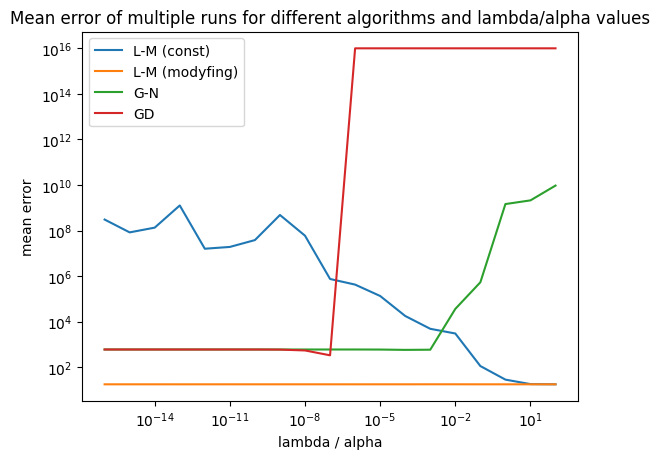

In [164]:
plt.loglog(lambda_params, errors_mean_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_mean_lm_mod, label="L-M (modyfing)")
plt.loglog(lambda_params, errors_gn_mean, label="G-N")
plt.loglog(lambda_params, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

In [165]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

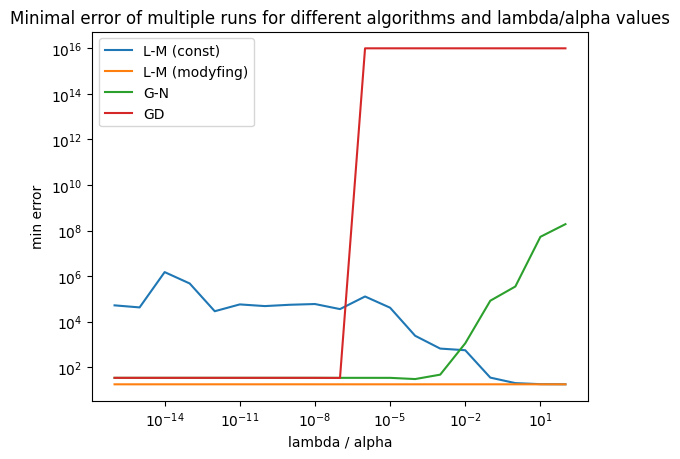

In [166]:
plt.loglog(lambda_params, errors_min_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_min_lm_mod, label="L-M (modyfing)")
plt.loglog(lambda_params, errors_gn_min, label="G-N")
plt.loglog(lambda_params, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("min error")
plt.title("Minimal error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

## Test number of iterations

In [167]:
max_iters = [2**i for i in range(0, 12)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
alpha_gd = 1e-8
alpha_gn = 1e-3
lambda0 = 1.
lambda_change = 2.

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/12)
max_iter: 2 (2/12)
max_iter: 4 (3/12)
max_iter: 8 (4/12)
max_iter: 16 (5/12)
max_iter: 32 (6/12)
max_iter: 64 (7/12)
max_iter: 128 (8/12)
max_iter: 256 (9/12)
max_iter: 512 (10/12)
max_iter: 1024 (11/12)
max_iter: 2048 (12/12)


In [168]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

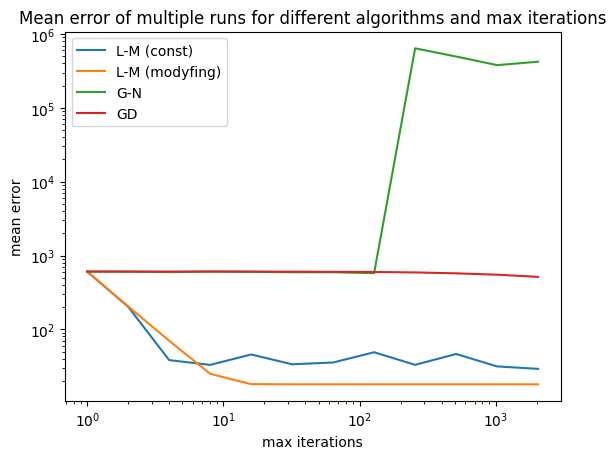

In [169]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (modyfing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()

In [170]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

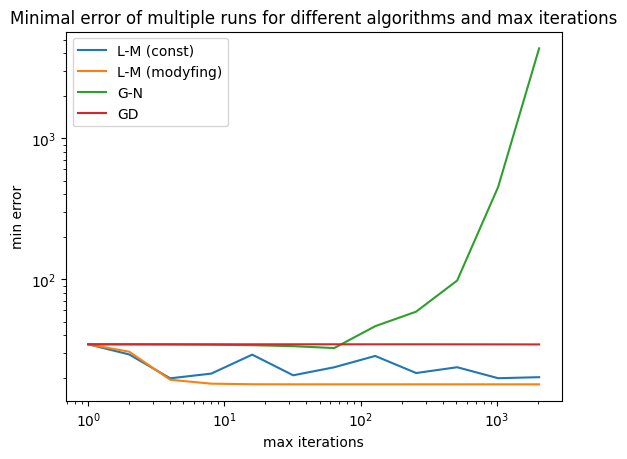

In [171]:
plt.loglog(max_iters, errors_min_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_min_lm_mod, label="L-M (modyfing)")
plt.loglog(max_iters, errors_gn_min, label="G-N")
plt.loglog(max_iters, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("min error")
plt.title("Minimal error of multiple runs for different algorithms and max iterations")
plt.show()